# 

Image classification using CLIP works by comparing a string of text with
an image. If we compare multiple text-strings with the same image, we
can determine the phrase with the highest similarity score and infer the
classification. To make the classification work for my scenario, I
created a dictionary, where each image type is mapped to multiple
sentences describing how an image in this class would look like.

<figure>
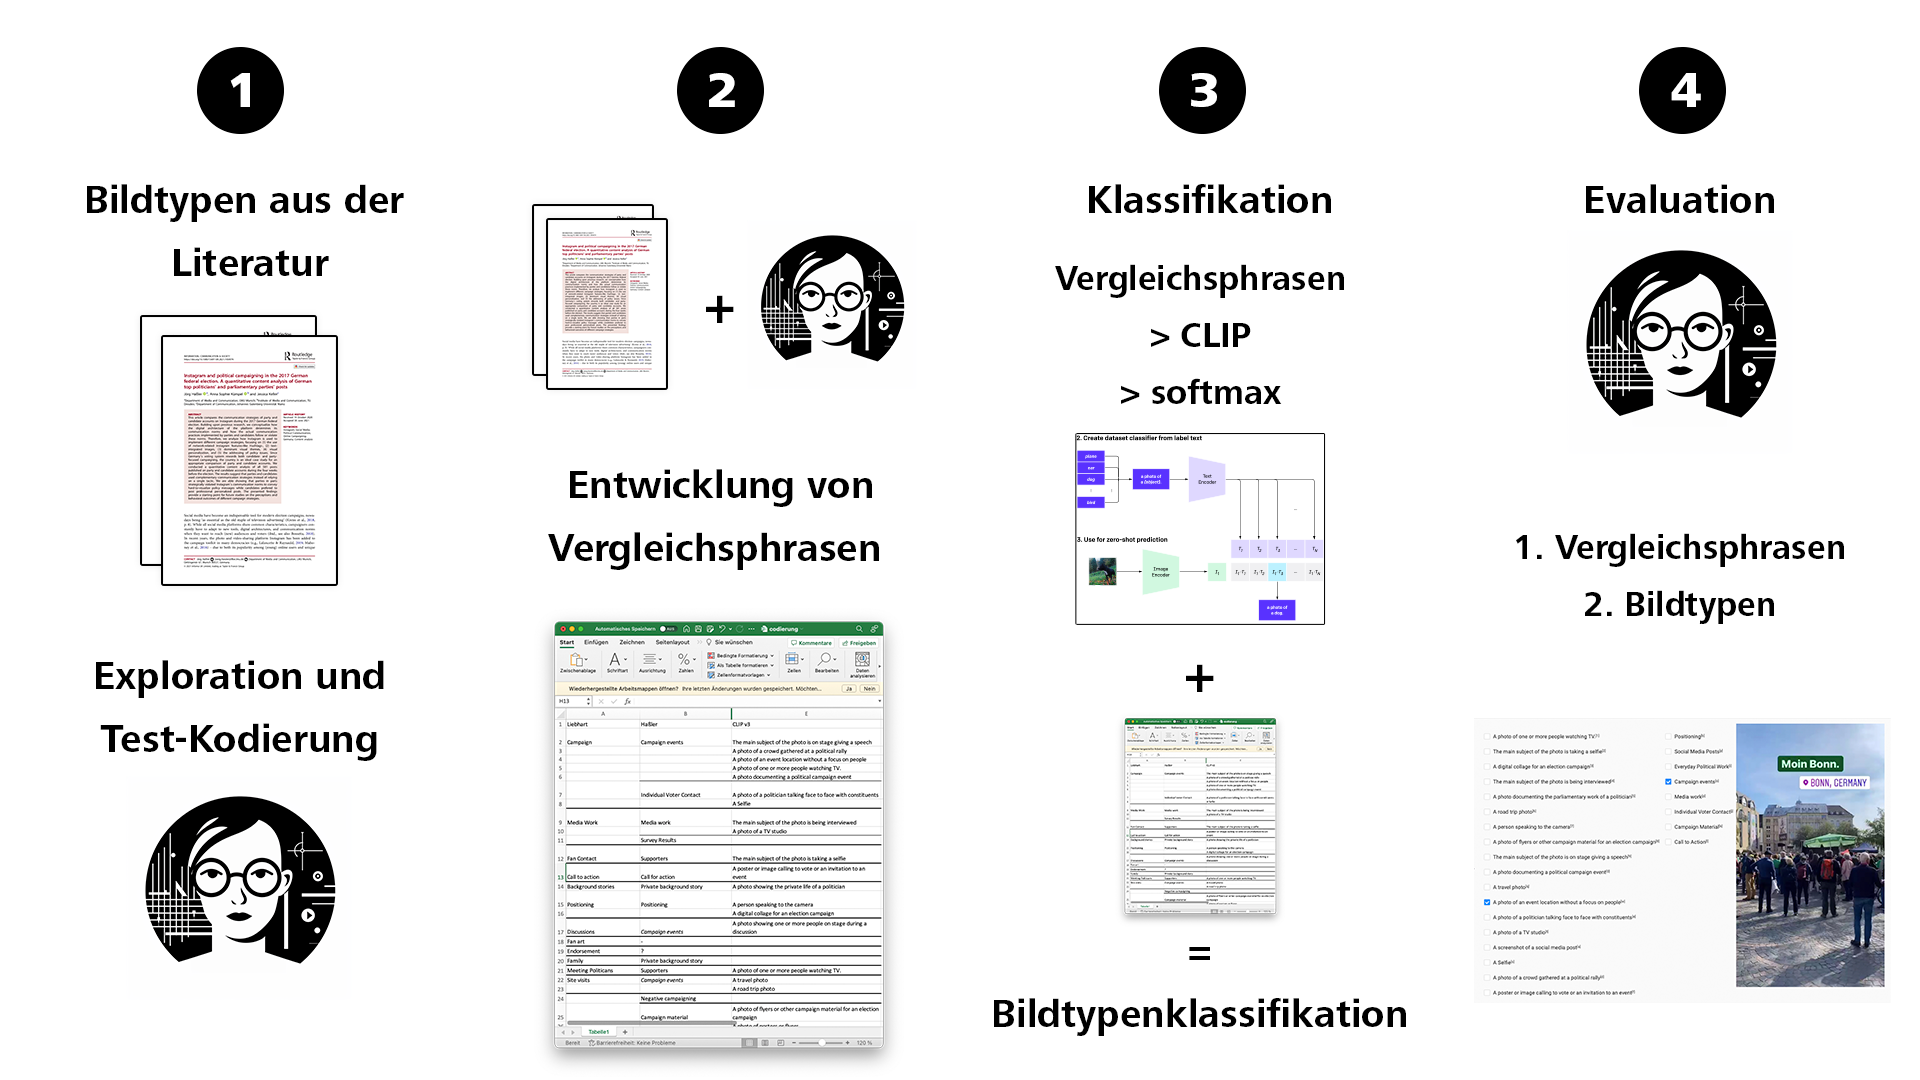
<figcaption aria-hidden="true">An overview of the CLIP-Classification
process, starting with the creation of phrases describing the target
content.</figcaption>
</figure>

My implementation is inspired by [this medium
story](https://medium.com/@JettChenT/image-classification-with-openai-clip-3ab5f1c23e35).

In [ ]:
classification_dict = {
    "Collages": [
        "A screenshot with multiple visual elements such as text, graphics, and images combined.",
    ],
    "Campaign Material": [
        "An image primarily showcasing election-related flyers, brochures, or handouts.",
        "A distinct promotional poster for a political event or campaign.",
        "Visible printed material urging people to vote or join a political cause."
    ],
    "Political Events": [
        "An image distinctly capturing the essence of a political campaign event.",
        "A location set for a political event, possibly without a crowd.",
        "A large assembly of supporters or participants at an open-air political rally.",
        "Clear visuals of a venue set for a significant political gathering or convention.",
        "Focused visuals of attendees or participants of a political rally or event.",
        "Inside ambiance of a political convention or major political conference.",
        "Prominent figures or speakers on stage addressing a political audience.",
        "A serene image primarily focused on landscapes, travel.",
        "Food, beverages, or generic shots."
    ],
    "Individual Contact": [
        "A politician genuinely engaging or interacting with individuals or small groups.",
        "A close-up or selfie, primarily showcasing an individual, possibly with political affiliations.",
        "An informal or candid shot with emphasis on individual engagement, perhaps in a political setting."
    ],
    "Interviews & Media": [
        "An indoor setting, well-lit, designed for professional media interviews or broadcasts.",
        "Clear visuals of an interviewee in a controlled studio environment.",
        "Microphone or recording equipment predominantly in front of a speaker indoors.",
        "Behind-the-scenes ambiance of a media setup or broadcast preparation.",
        "Visuals from a TV or media broadcast, including distinct channel or media branding.",
        "Significant media branding or logos evident, possibly during an interview or panel discussion.",
        "Structured indoor setting of a press conference or media event with multiple participants."
    ],
    "Social Media Moderation": [
        "Face-centric visual with the individual addressing or connecting with the camera.",
        "Emphasis on facial features, minimal background distractions, typical of online profiles.",
        "Portrait-style close-up of a face, without discernible logos, graphics, or overlays."
    ],
}

Using this dictionary, we can now compare the images to the strings
using CLIP in a loop.

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
from PIL import Image

# Assuming preprocess, clip model, and device are already initialized

def classify_images_with_clip(image_files, classification_dict, column_name, BATCH_SIZE=500):
    labels_map, flat_labels = flatten_classification_dict(classification_dict)
    text = clip.tokenize(flat_labels).to(device)

    results = []
    for batch_start in tqdm(range(0, len(image_files), BATCH_SIZE)):
        batch_end = batch_start + BATCH_SIZE
        batch_files = image_files[batch_start:batch_end]
        images = preprocess_images(batch_files)
        if not images:
            continue
        image_input = torch.tensor(np.stack(images)).to(device)

        logits_per_image = model_inference(image_input, text)
        update_results(logits_per_image, batch_files, flat_labels, labels_map, results, column_name)

    return pd.DataFrame(results)

def flatten_classification_dict(classification_dict):
    labels_map = {}
    flat_labels = []
    for category, phrases in classification_dict.items():
        for phrase in phrases:
            flat_labels.append(phrase)
            labels_map[phrase] = category
    return labels_map, flat_labels

def preprocess_images(image_files):
    images = []
    for img_file in image_files:
        try:
            image = preprocess(Image.open(img_file))
            images.append(image)
        except IOError:
            print(f"Error loading image: {img_file}")
    return images

def model_inference(image_input, text):
    with torch.no_grad():
        logits_per_image, _ = model(image_input, text)
        return logits_per_image.softmax(dim=-1).cpu().numpy() * 100

def update_results(logits_per_image, batch_files, flat_labels, labels_map, results, column_name):
    max_indices = np.argsort(logits_per_image, axis=1)[:, -2:]
    for idx, (file, top_indices) in enumerate(zip(batch_files, max_indices)):
        result = {"Image": file}
        for rank, label_idx in enumerate(top_indices[::-1], 1):
            label = flat_labels[label_idx]
            category = labels_map[label]
            prob = logits_per_image[idx, label_idx].round(2)
            result.update({
                f"{column_name}_{rank}": category,
                f"{column_name}_label_{rank}": label,
                f"{column_name}_prob_{rank}": prob
            })
        results.append(result)

def update_results(logits_per_image, batch_files, flat_labels, labels_map, results, column_name):
    max_indices = np.argmax(logits_per_image, axis=1)
    for idx, (file, top_index) in enumerate(zip(batch_files, max_indices)):
        label = flat_labels[top_index]
        category = labels_map[label]
        prob = logits_per_image[idx, top_index].round(2)  # Fixed probability extraction

        result = {
            "Image": file,
            f"{column_name}": category,
            f"{column_name} Label": label,
            f"{column_name} Probability": prob
        }
        results.append(result)




In [ ]:
import os

image_files = df['Image'].unique()

# Perform the classification and get the results as a DataFrame
classified_df = classify_images_with_clip(image_files, classification_dict, 'Classification')

The `classified_df` contains the classification results. This
implementation just saves the highest probability labels and
classifications.

In [ ]:
classified_df.head()

**Qualitative Evaluation** Running the last cells in the notebook
creates a visual overview of the classification results. *n* images are
sampled and displayed per group. The qualitative evaluation **does not
replace proper external validation!**. Additionally, the overview is
saved to `{current_date}-CLIP-Classification.html`. Download the file
and open it in your browser for a better layout. The second validation
cell creates a simple interface displaying on image and the
classification result. Click on the “Right” or “Wrong” button to browse
through multiple images and get a rough feeling of the classification
qualities.